---
title: Analytical STEM CTF ingredients
authors: [Julie Marie Bekkevold, Georgios Varnavides]  
date: 2025-03-31  
---

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import ctf # import custom plotting / utils
import cmasher as cmr 
import tqdm

In [2]:
# parameters
n = 96
q_max = 2 # inverse Angstroms
q_probe = 1 # inverse Angstroms
wavelength = 0.019687 # 300kV
sampling = 1 / q_max / 2 # Angstroms
reciprocal_sampling = 2 * q_max / n # inverse Angstroms

scan_step_size = 1 # pixels
sx = sy = n//scan_step_size
phi0 = 1.0

In [3]:
def white_noise_object_2D(n, phi0):
    """ creates a 2D real-valued array, whose FFT has random phase and constant amplitude """

    evenQ = n%2 == 0
    
    # indices
    pos_ind = np.arange(1,(n if evenQ else n+1)//2)
    neg_ind = np.flip(np.arange(n//2+1,n))

    # random phase
    arr = np.random.randn(n,n)
    
    # top-left // bottom-right
    arr[pos_ind[:,None],pos_ind[None,:]] = -arr[neg_ind[:,None],neg_ind[None,:]]
    # bottom-left // top-right
    arr[pos_ind[:,None],neg_ind[None,:]] = -arr[neg_ind[:,None],pos_ind[None,:]]
    # kx=0
    arr[0,pos_ind] = -arr[0,neg_ind]
    # ky=0
    arr[pos_ind,0] = -arr[neg_ind,0]

    # zero-out components which don't have k-> -k mapping
    if evenQ:
        arr[n//2,:] = 0 # zero highest spatial freq
        arr[:,n//2] = 0 # zero highest spatial freq

    arr[0,0] = 0 # DC component

    # fourier-array
    arr = np.exp(2j*np.pi*arr)*phi0

    # inverse FFT and remove floating point errors
    arr = np.fft.ifft2(arr).real
    
    return arr

# potential
potential = white_noise_object_2D(n,phi0)
complex_obj = np.exp(1j*potential)

In [4]:
# we build probe in Fourier space, using a soft aperture

qx = qy = np.fft.fftfreq(n,sampling)
q2 = qx[:,None]**2 + qy[None,:]**2
q  = np.sqrt(q2)

x = y = np.arange(0.,n,scan_step_size)
xx, yy = np.meshgrid(x,y,indexing='ij')
positions = np.stack((xx.ravel(),yy.ravel()),axis=-1)
row, col = ctf.return_patch_indices(positions,(n,n),(n,n))

probe_array_fourier_0 = np.sqrt(
    np.clip(
        (q_probe - q)/reciprocal_sampling + 0.5,
        0,
        1,
    ),
)

In [5]:
def autocorrelation(array):
    """ """
    return np.real(
        np.fft.ifft2(
            np.abs(
                np.fft.fft2(
                    array
                )
            )**2
        )
    )

probe_array_fourier_0_normalized = probe_array_fourier_0 / np.sqrt(np.sum(probe_array_fourier_0**2))
aperture_autocorrelation = autocorrelation(probe_array_fourier_0_normalized)

In [6]:
centered_aperture = np.fft.fftshift(probe_array_fourier_0)
padded_aperture = np.pad(centered_aperture,n//4)

def roll_padded_array(shift_px):
    """ """
    return np.roll(
        padded_aperture,
        shift_px,
        axis=(0,1)
    )[n//4:-n//4,n//4:-n//4]

def double_overlap_difference(shift_px):
    """ """
    array_1 = centered_aperture
    array_2 = roll_padded_array(shift_px)
    return array_2 - array_1

def double_overlap_union(shift_px):
    """ """

    array_1 = centered_aperture
    array_2 = roll_padded_array(shift_px)
    return (array_2 + array_1).clip(0,1)

def double_overlap(shift_px,ax):
    im = ax.imshow(
        double_overlap_difference(shift_px),
        alpha = double_overlap_union(shift_px),
        cmap='PiYG',
        vmin=-1.5,
        vmax=1.5,  
    )

    return im

In [40]:
def radially_average_ctf(
    corner_centered_ctf,
    sampling=(sampling,sampling)
):
    """ returns the radially-averaged CTF of a corner-centered 2D CTF array. """
    nx, ny = corner_centered_ctf.shape
    sx, sy = sampling
    
    kx = np.fft.fftfreq(nx,sx)
    ky = np.fft.fftfreq(ny,sy)
    k  = np.sqrt(kx[:,None]**2 + ky[None,:]**2).ravel()

    intensity = corner_centered_ctf.ravel()

    bin_size = kx[1]-kx[0]
    k_bins = np.arange(0, k.max() + bin_size, bin_size)

    inds = k / bin_size
    inds_f = np.floor(inds).astype("int")
    d_ind = inds - inds_f

    nf = np.bincount(inds_f, weights=(1 - d_ind), minlength=k_bins.shape[0])
    nc = np.bincount(inds_f + 1, weights=(d_ind), minlength=k_bins.shape[0])
    n = nf + nc

    I_bins0 = np.bincount(
        inds_f, weights=intensity * (1 - d_ind), minlength=k_bins.shape[0]
    )
    I_bins1 = np.bincount(
        inds_f + 1, weights=intensity * (d_ind), minlength=k_bins.shape[0]
    )

    I_bins = (I_bins0 + I_bins1) / n

    # inds = k_bins <= np.abs(kx).max()

    return k_bins, I_bins

q_bins, I_bins = radially_average_ctf(aperture_autocorrelation)

/tmp/ipykernel_46774/3952800199.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(680/dpi,500/dpi),dpi=dpi,layout="constrained")


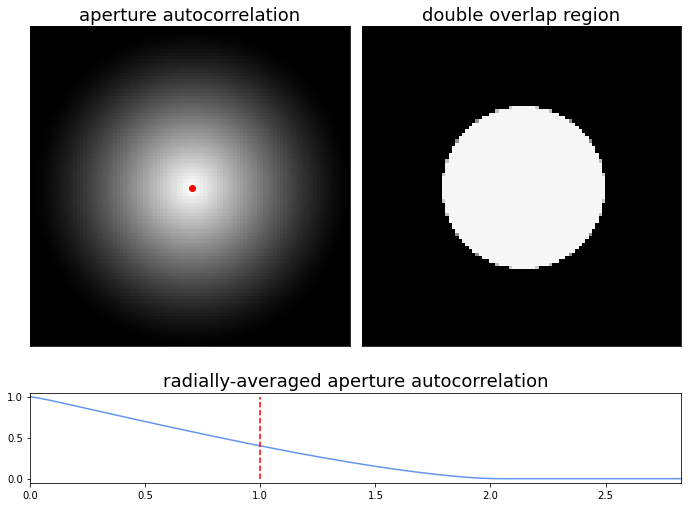

In [44]:
# visualization
with plt.ioff():
    dpi=72
    fig = plt.figure(figsize=(680/dpi,500/dpi),dpi=dpi,layout="constrained")

gs = GridSpec(3,4,figure=fig,height_ratios=[2,2,1])
ax_0 = fig.add_subplot(gs[:2,:2])
ax_1 = fig.add_subplot(gs[:2,2:])
ax_2 = fig.add_subplot(gs[2,:])

ax_0.imshow(np.fft.fftshift(aperture_autocorrelation),cmap = 'gray')
ax_0.set(xticks=[],yticks=[])
ax_0.set_title("aperture autocorrelation",fontsize=18)
scatter = ax_0.scatter(n//2,n//2,color='red')

im = double_overlap((0,0),ax_1)
ax_1.set_title("double overlap region",fontsize=18)

ax_1.set(
    facecolor='black',
    xticks=[],
    yticks=[]
)

ax_2.plot(q_bins,I_bins,color='cornflowerblue')
ax_2.set_title("radially-averaged aperture autocorrelation",fontsize=18)
ax_2.set(
    xlim=[0,2*np.sqrt(2)],
    ylim=[-0.05,1.05]
)
vline = ax_2.vlines(1,0,1,color='red',linestyle='--')
# gs.tight_layout(fig)

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '680px'
fig.canvas.layout.height = "550px"
fig.canvas.toolbar_position = 'bottom'
fig

In [45]:
def update_plot(shift_px):
    """ """
    scatter.set_offsets([np.flip(shift_px)])
    q = np.linalg.norm((shift_px-n//2)*reciprocal_sampling)
    vline.set_segments([np.array([[q,0],[q,1]])])
    im.set_data(double_overlap_difference(shift_px-n//2))
    im.set_alpha(double_overlap_union(shift_px-n//2))
    fig.canvas.draw_idle()
    return None

def onmove(event):
    """ """
    pos = np.array([event.ydata,event.xdata])
    
    if event.inaxes == ax_0 and pos[0] is not None:
        update_plot(pos)
        
cid = fig.canvas.mpl_connect('motion_notify_event',onmove)

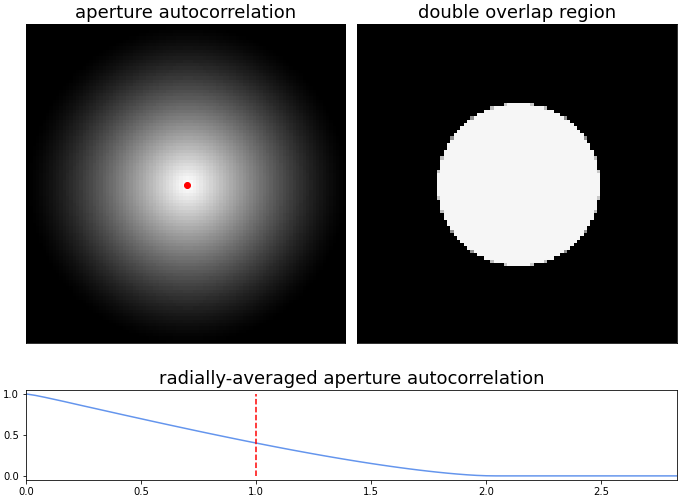

In [46]:
fig.canvas